# Comparison of Point-wise and Pair-wise Object Ranking on the MNIST Dataset

In [ ]:
%pip install numpy scipy tensorflow keras tensorflow_datasets funcy matplotlib
import os
import numpy as np
import scipy.sparse as sp
import scipy.stats as ss
import funcy as fy
import functools
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Load and Prepare Data

In [ ]:
(ds_train, ds_test), info = tfds.load(
  "mnist", 
  split=["train", "test"], shuffle_files=True, data_dir=".cache/mnist", 
  as_supervised=True, with_info=True)

def normalize_instance(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_instance).cache()
ds_test = ds_test.map(normalize_instance).cache()

In [3]:
def partition_dataset(ds, size, seed=42):
  X, y = fy.first(ds.batch(size))
  X = X.numpy()
  y = y.numpy()
  # Compute the indices of all 0-, 1-, ..., 9-digit images:
  r = np.arange(size)
  S = sp.csr_matrix((r, [y, r]), shape=(10, size))
  parts = np.split(S.data, S.indptr[1:-1])
  # Shuffle the indices in each digit bin:
  rnd = np.random.default_rng(seed)
  for part in parts:
    rnd.shuffle(part)
  # Consecutively take one index from each digit bin to build 10-element partitions:
  # (leftover digits from the bins larger than the smallest one will be ignored)
  random_partitions = np.array(list(p for p in zip(*parts)), dtype=np.int32)
  return random_partitions
  
test_partitions = partition_dataset(ds_test, info.splits["test"].num_examples)
  

In [4]:
def kendalls_tau(pred_utils, test_partitions):
  partition_preds = pred_utils[test_partitions]
  partition_rank_preds = ss.rankdata(partition_preds, method="ordinal", axis=-1)
  r = np.arange(1,11)
  taus = np.array([ss.kendalltau(ranking, r)[0] for ranking in partition_rank_preds])
  return taus.mean()

def tau_to_dist(tau, K=10):
  return (1 - tau) * K * (K-1) / 4

def plot_training_histories(*histories):
  fig, ax = plt.subplots()
  loss = np.mean([h.history["loss"] for h in histories], axis=0)
  val_loss = np.mean([h.history["val_loss"] for h in histories], axis=0)
  ax.plot(loss, label="Train")
  ax.plot(val_loss, label="Test")
  ax.set_ylabel("loss")
  ax.set_xlabel("epoch")
  ax.legend()
  plt.show()

## Point-wise Model

In [5]:
ds_train_pointwise = ds_train \
  .shuffle(info.splits["train"].num_examples) \
  .batch(6000) \
  .prefetch(tf.data.AUTOTUNE)
ds_test_pointwise = ds_test.batch(10000).prefetch(tf.data.AUTOTUNE)

In [6]:
def createPointwiseModel():
  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="relu"),
  ])
  model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MAE]
  )
  
  return model

mlps = []
hs = []
for i in range(3):
  print(f"Training repeat {i+1}/3...")
  mlp = createPointwiseModel()
  h = mlp.fit(ds_train_pointwise, validation_data=ds_test_pointwise, epochs=200, verbose=2)
  mlps.append(mlp)
  hs.append(h)

Training repeat 1/3...
Epoch 1/200
10/10 - 2s - loss: 17.2219 - mean_absolute_error: 3.3570 - val_loss: 10.9199 - val_mean_absolute_error: 2.6836 - 2s/epoch - 224ms/step
Epoch 2/200
10/10 - 0s - loss: 7.5150 - mean_absolute_error: 2.2770 - val_loss: 5.0770 - val_mean_absolute_error: 1.9064 - 211ms/epoch - 21ms/step
Epoch 3/200
10/10 - 0s - loss: 4.9072 - mean_absolute_error: 1.8412 - val_loss: 4.2846 - val_mean_absolute_error: 1.6864 - 213ms/epoch - 21ms/step
Epoch 4/200
10/10 - 0s - loss: 4.1927 - mean_absolute_error: 1.6483 - val_loss: 3.5627 - val_mean_absolute_error: 1.5043 - 202ms/epoch - 20ms/step
Epoch 5/200
10/10 - 0s - loss: 3.5588 - mean_absolute_error: 1.4855 - val_loss: 3.0107 - val_mean_absolute_error: 1.3445 - 197ms/epoch - 20ms/step
Epoch 6/200
10/10 - 0s - loss: 3.0011 - mean_absolute_error: 1.3091 - val_loss: 2.5804 - val_mean_absolute_error: 1.1814 - 195ms/epoch - 20ms/step
Epoch 7/200
10/10 - 0s - loss: 2.5550 - mean_absolute_error: 1.1673 - val_loss: 2.2612 - val_me

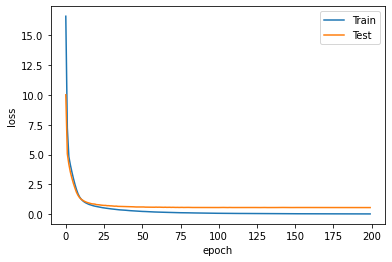

1/1 [==============================] - 0s 63ms/step
Mean Kendall's tau of point-wise MLP regressor: 0.9427171566185019
Mean Kendall distance of point-wise MLP regressor: 1.2888639760837073


In [7]:
plot_training_histories(*hs)

tau_pointwise = 0
dist_pointwise = 0
for mlp in mlps:
  pred_utils = mlp.predict(ds_test_pointwise).reshape(-1)
  tau = kendalls_tau(pred_utils, test_partitions)
  tau_pointwise += tau
  dist_pointwise += tau_to_dist(tau)
print(f"Mean Kendall's tau of point-wise MLP regressor: {tau_pointwise/3}")
print(f"Mean Kendall distance of point-wise MLP regressor: {dist_pointwise/3}")

## Pair-wise Model

In [8]:
def sample_preference_pairs(y: np.array, radius=4, sampling_ratio=100, seed=42):
  size = len(y)
  sample_size = size * radius * sampling_ratio
  r = np.arange(len(y))
  S = sp.csr_matrix((r, [y, r]), shape=(10, size))
  parts = np.split(S.data, S.indptr[1:-1])
  rnd = np.random.default_rng(seed)
  for part in parts:
    rnd.shuffle(part)
  idx_a = np.empty((sample_size,), dtype=np.int32)
  idx_b = np.empty((sample_size,), dtype=np.int32)
  target = np.ones((sample_size,), dtype=np.float32)
  k = 0
  for i in range(10):
    part = parts[i]
    psize = len(part)
    for d in range(radius):
      ni = (i+d+1) % 10
      npart = parts[ni]
      npsize = len(npart)
      for j in range(sampling_ratio):
        npart_offset = np.roll(npart, d * sampling_ratio + j)
        idx_a[k:k+psize] = part
        if npsize < psize:
          idx_b[k:k+npsize] = npart_offset
          idx_b[k+npsize:k+psize] = npart_offset[:psize-npsize]
        else:
          idx_b[k:k+psize] = npart_offset[:psize]
        if ni < i:
          target[k:k+psize] = 0
        k += psize
  return idx_a, idx_b, target

def to_pairwise_dataset(ds, size, **kwargs):
  X_train, y_train = fy.first(ds_train.batch(size))
  X_train = X_train.numpy()
  y_train = y_train.numpy()
  idx_a, idx_b, target = sample_preference_pairs(y_train, **kwargs)
  return tf.data.Dataset.from_tensors(((X_train, idx_a, idx_b), target))

ds_train_pairwise = to_pairwise_dataset(ds_train, info.splits["train"].num_examples)
ds_test_pairwise = to_pairwise_dataset(ds_test, info.splits["test"].num_examples, radius=1, sampling_ratio=1)

In [10]:
def pref_lookup(X, pref_a, pref_b):
  X_a = tf.gather(X, pref_a, axis=0)
  X_b = tf.gather(X, pref_b, axis=0)
  return X_a, X_b

def createPairwiseModel():
  X_input = keras.Input(shape=(28,28), dtype=tf.float32)
  pref_a = keras.Input(shape=(), dtype=tf.int32)
  pref_b = keras.Input(shape=(), dtype=tf.int32)
  X = keras.layers.Flatten(input_shape=(28,28))(X_input)
  
  for _ in range(4):
    X = keras.layers.Dense(128, activation="relu")(X)

  X_utils = keras.layers.Dense(1, activation="relu")(X)
  X_a, X_b = pref_lookup(X_utils, pref_a, pref_b)
  out = X_b - X_a

  m = keras.Model(
    inputs=(X_input, pref_a, pref_b), outputs=out,
    name="RankNet")
  m_infer = keras.Model(
    inputs=X_input, outputs=X_utils,
    name="RankNet_predictor")

  m.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(threshold=.0)])

  return m, m_infer

rns = []
hs = []
for i in range(3):
  print(f"Training repeat {i+1}/3...")
  rn, rn_inf = createPairwiseModel()
  h = rn.fit(ds_train_pairwise, validation_data=ds_test_pairwise, epochs=500, verbose=2)
  rns.append(rn_inf)
  hs.append(h)

Training repeat 1/3...
Epoch 1/500
1/1 - 1s - loss: 0.6991 - binary_accuracy: 0.4999 - val_loss: 0.6714 - val_binary_accuracy: 0.6073 - 862ms/epoch - 862ms/step
Epoch 2/500
1/1 - 0s - loss: 0.6494 - binary_accuracy: 0.7057 - val_loss: 0.6506 - val_binary_accuracy: 0.6196 - 147ms/epoch - 147ms/step
Epoch 3/500
1/1 - 0s - loss: 0.6117 - binary_accuracy: 0.7388 - val_loss: 0.6347 - val_binary_accuracy: 0.6314 - 148ms/epoch - 148ms/step
Epoch 4/500
1/1 - 0s - loss: 0.5691 - binary_accuracy: 0.7548 - val_loss: 0.6263 - val_binary_accuracy: 0.6391 - 144ms/epoch - 144ms/step
Epoch 5/500
1/1 - 0s - loss: 0.5301 - binary_accuracy: 0.7618 - val_loss: 0.6273 - val_binary_accuracy: 0.6422 - 122ms/epoch - 122ms/step
Epoch 6/500
1/1 - 0s - loss: 0.4986 - binary_accuracy: 0.7659 - val_loss: 0.6388 - val_binary_accuracy: 0.6424 - 141ms/epoch - 141ms/step
Epoch 7/500
1/1 - 0s - loss: 0.4763 - binary_accuracy: 0.7707 - val_loss: 0.6596 - val_binary_accuracy: 0.6442 - 149ms/epoch - 149ms/step
Epoch 8/500

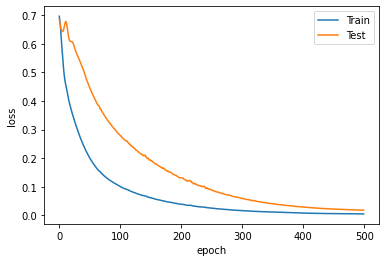

1/1 [==============================] - 0s 26ms/step
Mean Kendall's tau of pair-wise RankNet model: 0.939578143165587
Mean Kendall distance of pair-wise RankNet model: 1.3594917787742917


In [12]:
plot_training_histories(*hs)

tau_pairwise = 0
dist_pairwise = 0
for rn in rns:
  pred_utils = rn.predict(ds_test_pointwise).reshape(-1)
  tau = kendalls_tau(pred_utils, test_partitions)
  tau_pairwise += tau
  dist_pairwise += tau_to_dist(tau)
print(f"Mean Kendall's tau of pair-wise RankNet model: {tau_pairwise/3}")
print(f"Mean Kendall distance of pair-wise RankNet model: {dist_pairwise/3}")

In [13]:
import pandas as pd

pd.DataFrame([
  ["Point-wise MLP", dist_pointwise/3, tau_pointwise/3],
  ["Pair-wise RankNet", dist_pairwise/3, tau_pairwise/3]
], columns=["model", "dist", "tau"]).to_csv("exercise07.csv", index=False)